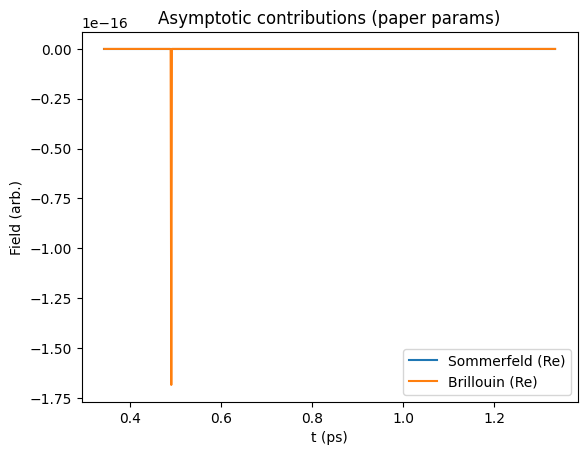

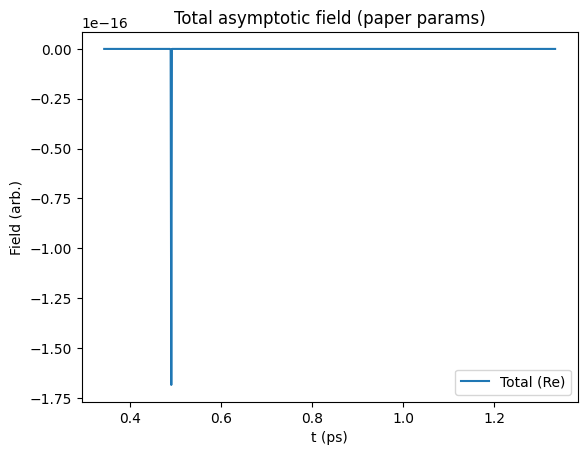

theta0 = 1.5
theta1 ≈ 1.5027401243680938
t_front = z/c = 3.3356409519815206e-13 s = 0.33356409519815206 ps
t1 ≈ theta1*z/c = 5.012601499028017e-13 s = 0.5012601499028018 ps


'/mnt/data/asymptotic_paper_params.csv'

In [4]:
# Re-running after state reset

import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
import pandas as pd
# from caas_jupyter_tools import display_dataframe_to_user

c = 299_792_458.0

class LorentzParams:
    def __init__(self, w0, b, delta):
        self.w0 = float(w0)
        self.b = float(b)
        self.delta = float(delta)
        self.theta0 = np.sqrt(1.0 + (b**2)/(w0**2))
        self.theta1 = self.theta0 + (2*delta**2*b**2)/(self.theta0*w0**2*(3*w0**2 - 4*delta**2))

def eps_lorentz(omega, p: LorentzParams):
    D = p.w0**2 - omega**2 - 2j*p.delta*omega
    return 1.0 + (p.b**2)/D

def eps_derivs(omega, p: LorentzParams):
    w = omega
    D  = p.w0**2 - w**2 - 2j*p.delta*w
    Dp = -2*(w + 1j*p.delta)
    Dpp = -2.0
    eps1 = (p.b**2) * ( -Dp / (D**2) )
    eps2 = (p.b**2) * ( -Dpp*(D**-2) + (-Dp)*(-2)*(D**-3)*Dp )
    return eps1, eps2

def n_and_derivs(omega, p: LorentzParams):
    eps = eps_lorentz(omega, p)
    n = mp.sqrt(eps)
    eps1, eps2 = eps_derivs(omega, p)
    if (omega.real >= 0) and (mp.im(omega*n) < 0):
        n = -n
    n1 = eps1/(2*n)
    n2 = eps2/(2*n) - (eps1**2)/(4*n**3)
    return n, n1, n2

def phi(omega, theta, p: LorentzParams):
    n, _, _ = n_and_derivs(omega, p)
    return 1j*omega*(n - theta)

def phi_derivs(omega, theta, p: LorentzParams):
    n, n1, n2 = n_and_derivs(omega, p)
    phi1 = 1j*(n + omega*n1 - theta)
    phi2 = 1j*(2*n1 + omega*n2)
    return phi1, phi2

def newton_saddle(theta, p, seed):
    w = complex(seed)
    for _ in range(60):
        phi1, phi2 = phi_derivs(w, theta, p)
        if abs(phi2) < 1e-24:
            break
        step = phi1 / phi2
        w = w - step
        if abs(step) < 1e-12 * max(1.0, abs(w)):
            return w, True
    return w, False

def unique_roots(pairs, tol=1e-8):
    out = []
    for w, ok in pairs:
        if not ok:
            continue
        keep = True
        for u in out:
            if abs(w-u) < tol*max(1.0, abs(w), abs(u)):
                keep = False
                break
        if keep:
            out.append(w)
    return out

def find_saddles(theta, p: LorentzParams):
    w0, d = p.w0, p.delta
    seeds = [
        1e-6+0j, 1e-3*w0+0j, 1e-2*w0+0.2j*d,
        0.7*w0+0.3j*d, w0+0.5j*d, 1.3*w0+0.8j*d,
        3*w0+0.2j*d, 5*w0+0.5j*d, 8*w0+1j*d, 0.4j*w0
    ]
    cand = [newton_saddle(theta, p, s) for s in seeds]
    roots = [w for w in unique_roots(cand) if w.real > 0]
    if not roots:
        return None, None
    roots = sorted(roots, key=lambda w: abs(w))
    near = roots[0]
    distant = roots[-1] if len(roots) > 1 else None
    return distant, near

def u_tilde(omega_shift, T, wc, t0, psi):
    return (np.sqrt(np.pi)*T)*mp.e**(-(T**2/4.0)*(omega_shift**2)) * mp.e**(-1j*(wc*t0 + psi))

def A_j(z, t, theta, w_sp, aj, T, wc, t0, psi, p: LorentzParams):
    if w_sp is None:
        return 0.0
    _, phi2 = phi_derivs(w_sp, theta, p)
    if abs(phi2) < 1e-22:
        return 0.0
    sq = mp.sqrt(-phi2)
    U  = u_tilde(w_sp - wc, T, wc, t0, psi)
    pref = aj * mp.sqrt(c/(2*np.pi*z))
    return complex(pref * mp.re( 1j*(U/sq) * mp.e**((z/c)*phi(w_sp, theta, p)) ))

def A_total(z, t_arr, p: LorentzParams, T, wc=0.0, t0=0.0, psi=0.0):
    A  = np.zeros_like(t_arr, dtype=np.complex128)
    AS = np.zeros_like(t_arr, dtype=np.complex128)
    AB = np.zeros_like(t_arr, dtype=np.complex128)
    for i, t in enumerate(t_arr):
        theta = c*t/z
        wS, wB = find_saddles(theta, p)
        aS = 2.0
        aB = 1.0 if (theta < p.theta1) else 2.0
        AS[i] = A_j(z, t, theta, wS, aS, T, wc, t0, psi, p)
        AB[i] = A_j(z, t, theta, wB, aB, T, wc, t0, psi, p)
        A[i]  = AS[i] + AB[i]
    return A, AS, AB

# Paper parameters
T   = 0.1e-15
wc  = 5.75e16
w0  = 4.0e16
b   = np.sqrt(20.0e32)
delta = 0.28e16
p = LorentzParams(w0, b, delta)

# Geometry
z = 1.0e-4
t_front = z/c
t1 = p.theta1 * z / c

# Time grid
t = np.linspace(1.03*t_front, 4.0*t_front, 700)
A, AS, AB = A_total(z, t, p, T, wc, 0.0, 0.0)

# plots
plt.figure()
plt.plot(t*1e12, np.real(AS), label="Sommerfeld (Re)")
plt.plot(t*1e12, np.real(AB), label="Brillouin (Re)")
plt.xlabel("t (ps)"); plt.ylabel("Field (arb.)"); plt.title("Asymptotic contributions (paper params)")
plt.legend(); plt.show()

plt.figure()
plt.plot(t*1e12, np.real(A), label="Total (Re)")
plt.xlabel("t (ps)"); plt.ylabel("Field (arb.)"); plt.title("Total asymptotic field (paper params)")
plt.legend(); plt.show()

df = pd.DataFrame({
    "t_ps": t*1e12,
    "A_Re": np.real(A),  "A_Im": np.imag(A),
    "AS_Re": np.real(AS),"AB_Re": np.real(AB),
})
# display_dataframe_to_user("asymptotic_paper_params_preview.csv (preview)", df.head(30))
out_path = "/mnt/data/asymptotic_paper_params.csv"
# df.to_csv(out_path, index=False)

print("theta0 =", p.theta0)
print("theta1 ≈", p.theta1)
print("t_front = z/c =", t_front, "s =", t_front*1e12, "ps")
print("t1 ≈ theta1*z/c =", t1, "s =", t1*1e12, "ps")
out_path


C:\Users\esmaru\AppData\Local\Temp\ipykernel_41636\1992864927.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I = np.trapz(integrand, w)


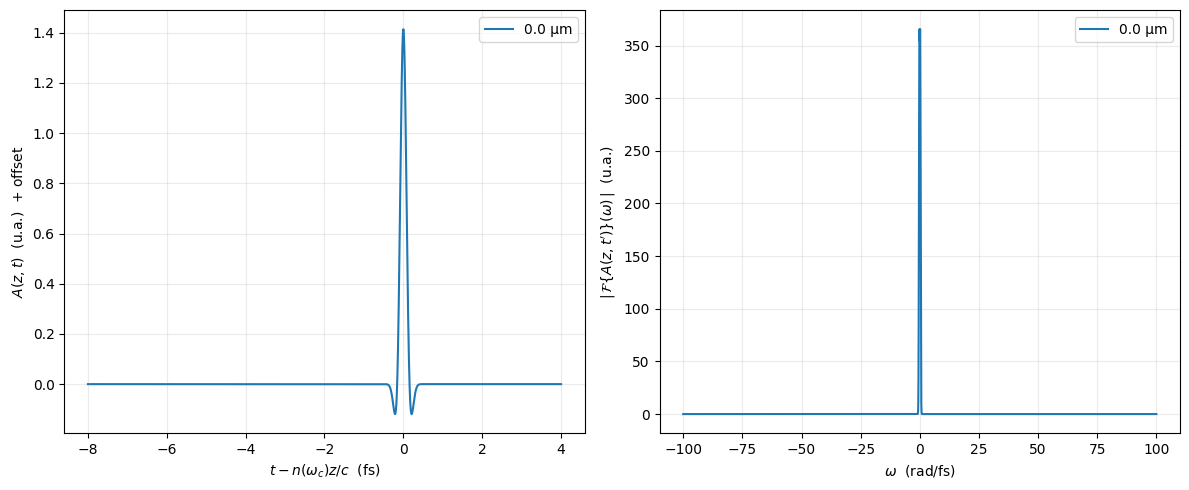

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Parámetros dados (unidades en 1/fs)
w0 = 40.0     # 1/fs
wp = 44.7     # 1/fs
gamma = 5.6   # 1/fs
wc = 10.0     # 1/fs
T = 0.314/2.0 # fs  -> T = 0.157 fs

# Constante de la luz en micrómetros por femtosegundo
c_um_fs = 0.299_792_458  # μm/fs

# ----------------------
# Malla de frecuencias
w_min, w_max = 0.0, 100.0          # 1/fs
Nw = 20000                          # puntos (suficientemente fino para el gaussiano)
w = np.linspace(-w_max, w_max, Nw)   # 1/fs
dw = w[1]-w[0]

# ----------------------
# Índice complejo n(ω) según n^2 = 1 - wp^2 / (ω^2 - w0^2 + i γ ω)
def n_complex(w):
    denom = (w**2 - w0**2) + 1j*gamma*w
    n2 = 1.0 - (wp**2)/denom
    n = np.sqrt(n2)  # raíz principa
    return n

n_w = n_complex(w)
k_w = n_w * w / c_um_fs   # 1/μm

# Espectro gaussiano (sólo positiva): exp[-(T^2/4)(ω-ωc)^2]
G = np.exp(- (T**2/4.0) * (w - wc)**2 )

# ----------------------
# Integral numérica para A(z,t)
def A_zt(z_um, t_fs):
    # I(t) ≈ ∫ G(ω) e^{i(kz - ω t)} dω  (trapezoidal)
    phase = np.exp(1j*(k_w*z_um - w*t_fs))
    integrand = G * phase
    # trapz en el eje ω (lineal)
    I = np.trapz(integrand, w)
    A = (T/np.sqrt(2.0*np.pi)) * np.real(I)
    return A

# ----------------------
# Eje temporal t' = t - n(wc) z / c
nz_wc = n_complex(wc)  # usamos la parte real para el corrimiento pedido
def trace_for_z(z_um, tprime_fs):
    t_fs = tprime_fs + (nz_wc*z_um/c_um_fs)
    A_vals = np.array([A_zt(z_um, ti) for ti in t_fs])
    return A_vals

# Rango temporal centrado en t' = 0 (suficiente para el pulso corto)
tprime = np.linspace(-8, 4, Nw )  # fs

# Z a evaluar (μm)
z_list = [0.0]

results = {}
for z in z_list:
    results[z] = trace_for_z(z, tprime)

# ----------------------
# --- Panel 1: señales desplazadas (como ya lo tienes) + Panel 2: espectros ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# -------- Panel izquierdo: A(z,t') apiladas --------
for cc, z in enumerate(z_list):
    y = results[z] + cc*1.3
    ax1.plot(tprime, y, label=f'{z} μm')
ax1.set_xlabel(r"$t - n(\omega_c) z/c$  (fs)")
ax1.set_ylabel(r"$A(z,t)$  (u.a.)  + offset")
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.25)

# -------- Panel derecho: |FT{A(z,t')}| con kernel e^{-i ω t} --------
# FFT continua aproximada:  F(ω) ≈ Δt * FFT{A(t)}  con ω = 2π * f

# Plot de cada z (magnitud). Usamos la señal SIN el offset ‘+cc’ para evitar un pico DC artificial
for z in z_list:
    y = results[z]
    Fw =  np.fft.fft(np.fft.fftshift(y))                   # convención e^{-i 2π f t}
    Fw = np.fft.fftshift(Fw)                   # centrar
    # nos quedamos con ω >= 0 y ω <= 100 rad/fs

    ax2.plot(w, np.abs(Fw), label=f'{z} μm')

ax2.set_xlabel(r"$\omega$  (rad/fs)")
ax2.set_ylabel(r"$|\,\mathcal{F}\{A(z,t')\}(\omega)\,|$  (u.a.)")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()



(0.0, 100.0)

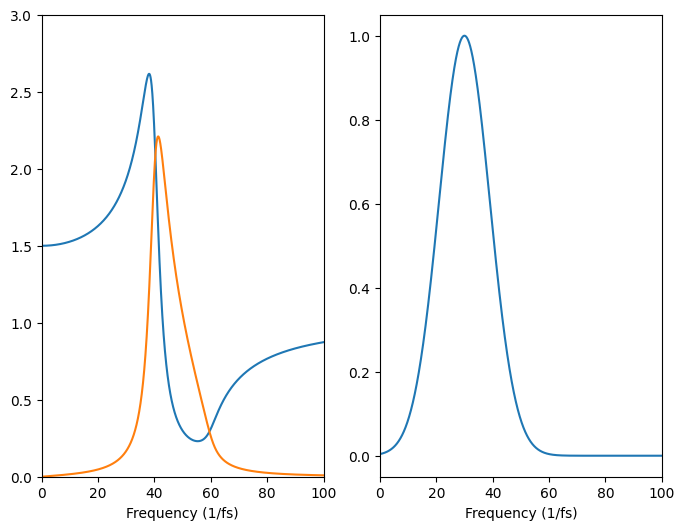

In [89]:
f = plt.figure(figsize=(8,6))
plt.subplot(121)
plt.plot(w,n_w.real, label="Re(n)")
plt.plot(w,n_w.imag, label="Re(n)")
plt.xlabel("Frequency (1/fs)")
plt.xlim(0,100)
plt.ylim(0,3)
wc = 30.0     # 1/fs
G = np.exp(- (T**2/4.0) * (w - wc)**2 )


plt.subplot(122)
plt.plot(w,G, label="Re(n)")
plt.xlabel("Frequency (1/fs)")
plt.xlim(0,100)